In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp profile

# Profile

> Set of functions for calculating roughness parameters along profiles 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis, moment
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
import math

from rough.data import *


In [ ]:
#| hide
from fastcore.test import *

In [ ]:
#| hide
#for tests
#The first datapoint in the reference files
#is the x axis resolution
cor2pgau = smooth_image(np.loadtxt('test_data/cor2pgau.txt')[1:],cutoff=1)
cor2pgau[:5]

array([-0.07611111, -0.10857497, -0.10039148, -0.14128181, -0.14291866])

In [ ]:
skew(cor2pgau)

0.9913808409840075

[<matplotlib.lines.Line2D>]

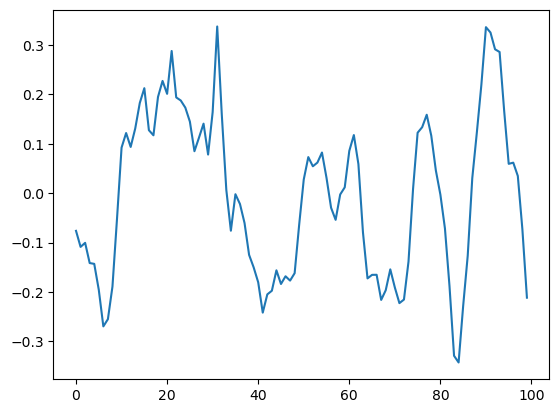

In [ ]:
plt.plot(cor2pgau[:100])

## Working on using a natural cubic spline interpolation 


[<matplotlib.lines.Line2D>]

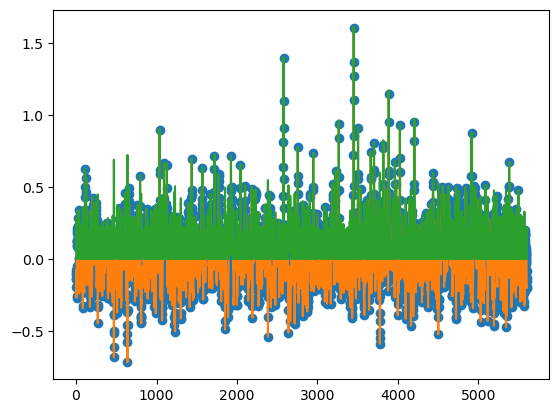

In [ ]:
cortest = cor2pgau
xvals = np.arange(0,len(cortest))
corspline = CubicSpline(xvals,cortest)
plt.plot(xvals,cortest,'o')
plt.plot(xvals,corspline(xvals))
plt.plot(np.arange(0,len(cortest),0.01),np.abs(corspline(np.arange(0,len(cortest),0.01))))

In [ ]:
corvals = corspline(np.arange(0,len(cortest),0.1))
100*(1 - ((np.amax(corvals) - np.amin(corvals))/2.3547816195993403))
#2.3547816195993403 Ref

0.597127641400097

In [ ]:
np.amin(corspline(np.arange(0,100,0.01)))

-0.3575198941292343

In [ ]:
np.arange(0, len(cor2pgau),1)

array([   0,    1,    2, ..., 5599, 5600, 5601])

In [ ]:
from scipy.integrate import quad

x = np.arange(0, len(cor2pgau)-500,1)
y = cor2pgau[250:-250]

# Fit a cubic spline
cs = CubicSpline(x, y)
amhs = []

for i in range(0,4750,250):
    interval_start = i
    interval_end = interval_start + 250

    # Define the function for integration (absolute value of the spline)
    def function_to_integrate(x):
        return np.abs(cs(x))

    # Calculate the arithmetic mean height using quad integration
    amh, _ = quad(function_to_integrate, interval_start, interval_end,limit=100)

    # Divide by the length of the interval
    interval_length = interval_end - interval_start
    amh /= interval_length
    amhs.append(amh)

print("Arithmetic Mean Height:", np.mean(amhs))
print("Reference Mean Height: ", 0.14539179526852036)

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_21536\1757459713.py:19: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  amh, _ = quad(function_to_integrate, interval_start, interval_end,limit=100)


Arithmetic Mean Height: 0.14486063527377357
Reference Mean Height:  0.14539179526852036


In [ ]:
x = np.arange(0, len(cor2pgau)-500,1)
y = cor2pgau[250:-250]

# Fit a cubic spline
cs = CubicSpline(x, y)
amhs = []

for i in range(0,4750,250):
    interval_start = i
    interval_end = interval_start + 250

    # Define the function for integration (absolute value of the spline)
    def function_to_integrate(x):
        return np.square(cs(x))

    # Calculate the arithmetic mean height using quad integration
    amh, _ = quad(function_to_integrate, interval_start, interval_end,limit=75)

    # Divide by the length of the interval
    interval_length = interval_end - interval_start
    amh /= interval_length
    amhs.append(np.sqrt(amh))

print("Arithmetic Rms:", np.mean(amhs))
print("Reference Rms: ", 0.195597300779425)
print('% Difference', (1-(np.mean(amhs)/0.195597300779425))*100)

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_21536\3442658834.py:17: IntegrationWarning: The maximum number of subdivisions (75) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  amh, _ = quad(function_to_integrate, interval_start, interval_end,limit=75)


Arithmetic Rms: 0.19243323201981133
Reference Rms:  0.195597300779425
% Difference 1.6176443882432667


[<matplotlib.lines.Line2D>]

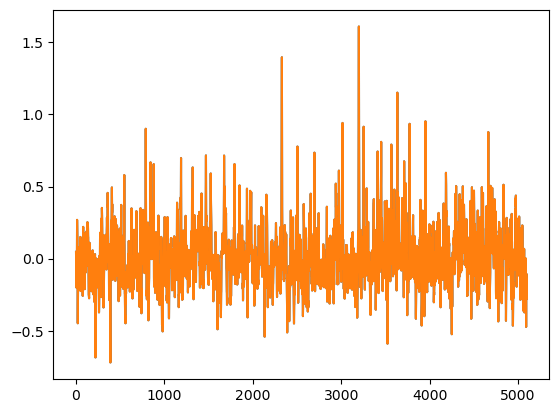

In [ ]:
plt.plot(x,cs(x))
plt.plot(x,y)

In [ ]:
cs(x).shape

(5102,)

In [ ]:
x = np.arange(0, len(cor2pgau)-500,.01)
skew(cs(x))

1.0357592588597104

To demonstrate, we're going to build on the data we processed in `data` 

In [ ]:
image = np.loadtxt('example.txt')
profiles = np.loadtxt('example_profiles.txt')

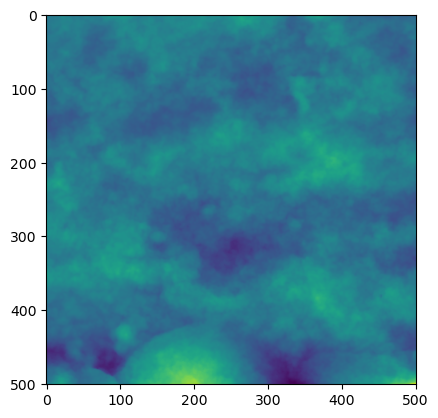

In [ ]:
plt.imshow(image)
plt.show()

## Statistical Parameters
The following methods are statistical in nature, providing a single number as a broad description of the distribution of the height values. 

In [ ]:
#| export
def Ra(im, #Numpy array or arraylike
       axis = 1, #Default to Ra of rows
       norm = True #Normalize the profile by subtracting the mean 
      ):
    '''
    Calculates Mean Absolute Roughness (Ra) along given axis. Defined as the average deviation of absolute height values from the mean line.
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.mean(np.absolute(im), axis = axis)

In [ ]:
test_close(0.14539179526852036,Ra(cor2pgau,norm=False,axis=None),eps=1e-4)

In [ ]:
Ra(image)[:5]

array([0.00042559, 0.00041652, 0.00040715, 0.00039409, 0.00037837])

Remember, if you just want the parameters of a certain profile, you just index into your image and be mindful of the axis. 

In [ ]:
first_row_profile    = image[0,:]
first_column_profile = image[:,0]
Ra(first_column_profile, axis = 0)

0.0004406996100199229

In [ ]:
#| export
def Rms(im, #Numpy array or array like
        axis = 1, #Default to Rms of rows
        norm = True #Normalize the profile by subtracting the mean
       ):
    '''
    Calculates Root Mean Square Roughness (Rms) along given axis. Defined as the root mean square of deviations of height from the mean line of a given profile. 
    
    Also known as Rq
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.sqrt(np.mean(np.square(im), axis = axis))

In [ ]:
test_close(0.195597300779425,Rms(cor2pgau,axis=None),1e-3)

AssertionError: close:
0.195597300779425
0.19277239906814556

In [ ]:
Rms(image)[:5]

In [ ]:
#| export
def Rsk(im, #Numpy array or array like
         axis = 1, #Default to Skew of rows
         norm = True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the skew function
       ):
    '''
    Calcultes the Skew (Rsk) along given axis. Thin wrapper around scipy.stats.skew with bias set to False
    '''
    if norm:
        im = im - np.mean(im, axis=axis, keepdims=True)
    return skew(a = im, axis=axis, **kwargs)

In [ ]:
test_close(1.094210880233907,Rsk(cor2pgau[50:-50],axis=None),1e-4)

AssertionError: close:
1.094210880233907
0.9981758360180745

In [ ]:
Rsk(image)[:5]

In [ ]:
#| export
def Rku(im, #Numpy array or array like
       axis = 1, #Default to Kurtosis of rows
       norm= True, #Normalize the profile by subtracting the mean
        **kwargs #Keyword arguments to modify the kurtosis function
       ):
    '''
    Calculates the Kurtosis (Rku) along given axis. This wrapper around scipy.stats.kurtosis 
    '''
    if norm:
        im = im - np.mean(im,axis=axis, keepdims=True)
    return kurtosis(a = im, axis = axis, **kwargs)

In [ ]:
test_close(6.8550747244379355,Rku(cor2pgau,axis=None),1e-4)

AssertionError: close:
6.8550747244379355
3.849727101576349

In [ ]:
Rku(image)[:5]

In [ ]:
#| export
def Rp(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amax function
         ):
    '''
    Calculates the peak height of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    return np.amax(im, axis = axis, **kwargs)
    

In [ ]:
test_close(1.1930965342677724,Rp(cor2pgau,axis=None),1e-4)

In [ ]:
#| export
def Rv(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.amin function
         ):
    '''
    Calculates the absolute max valley depth of the profile. 
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
        
    return abs(np.amin(im, axis = axis, **kwargs))

In [ ]:
test_close(0.5760229498158181,Rv(cor2pgau,axis=None),1e-4)

In [ ]:
#| export
def Rz(im, #Numpy array or array like
       axis = 1, # Default to peaks of rows
       norm = True, #Normalize the profile by subtracting the mean
       **kwargs #Keyword arguments to modify the numpy.ptp function
         ):
    '''
    Calculates the maximum height (max height + absolute max depth) of the profile. Synonymous with range. 
    Also called Rt
    '''
    
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    return np.ptp(im,axis = axis, **kwargs)

In [ ]:
test_close(1.7691194840835909,Rz(cor2pgau,axis=None),1e-4)

In [ ]:
## Texture Parameters


In [ ]:
def local_max_min(im,
                  axis = 1,
                  norm = True,
                  **kwargs
                 ):
    ''' 
    Returns the number of local maxima and minima per unit length, also known as the density of extremes from Nayak (1971).
    Assumes the surface is random, with a gaussian distribution of heights (usually pretty safe). 
    '''
    if norm:
        im = im - np.mean(im, axis = axis, keepdims = True)
    
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    return (1/math.pi) * ((m4/m2)**(1/2))
    

In [ ]:
def Sds(im,
        axis = 1,
        norm = True,
        **kwargs
       ):
    '''
    Density of summits, as described by Nayak (1971).
    Assumes gaussian, isotropic surface. 
    '''
    m2 = moment(im, moment=2, axis = axis)
    m4 = moment(im, moment=4, axis = axis)
    
    return (1 / (6 * math.pi * (3**(1/2)))) * (m4/m2)

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()